In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt
import neurokit2 as nk
from biosppy.signals import  ecg
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML

## Overview
***
*An airline pilot is one of the most extremely stressful and exhausting jobs without any proper workload management, this
issue is very common around the world because of scarcity of Airline pilots. Pilots need to take care of the 
safety of the thousands of passengers they transport around the world, but stress and completely tired brain make them 
lose attention easily and they failed to maintain focus, and the repercussion of that may be fatal
As this is the world problem not specific to the particular country, this needs to be resolved.*
***


## How to solve this problem to some extent?
***
Building a Machine Learning model to detect troubling events from aircrew’s `physiological data`.
Data acquired from actual pilots in test situations, and Machine learning model should be able to run calculations in real 
time to monitor the `cognitive states` of pilots. If Model detects anything peculiar in pilots cognitive states, then they
will be alerted and can regain their focus.
***

### Loading dataset

In [4]:
train_raw_data = pd.read_csv("train.csv")

In [5]:
print("Columns:")
train_raw_data.columns

Columns:


Index(['crew', 'experiment', 'time', 'seat', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr', 'event'],
      dtype='object')

In [12]:
print(f"Shape:{train_raw_data.shape}")

Shape:(4867421, 28)


In [7]:
train_raw_data['event'].value_counts()

A    2848809
C    1652686
D     235329
B     130597
Name: event, dtype: int64

# Exploratory Data Analysis

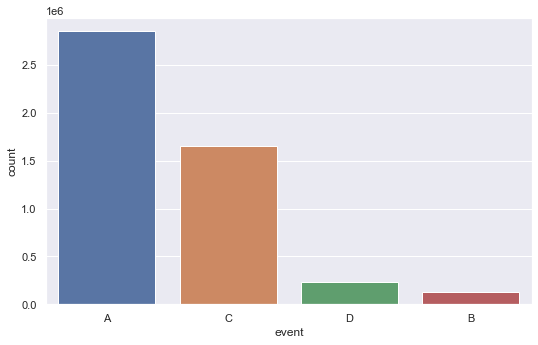

In [5]:
sns.set(rc={'figure.figsize':(8.7,5.27)})
sns.set(style="darkgrid")
sns.countplot(x ='event', data = train_raw_data)
plt.show()

* Data is highly imbalanced

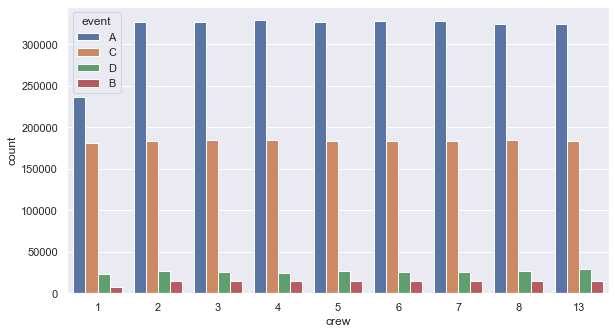

In [10]:
sns.set(rc={'figure.figsize':(9.7,5.27)})
sns.countplot(x = 'crew',
            hue = 'event',
            data = train_raw_data)
plt.show()

There are in total 9 Crews 
* For each crew the label(A,B,C,D) counts are comparable
* A = baseline, B = SS, C = CA, D = DA
***
* Channelized Attention (CA) is, roughly speaking, the state of being focused on one task to the exclusion of all others. This is induced in benchmarking by having the subjects play an engaging puzzle-based video game.
* Diverted Attention (DA) is the state of having one’s attention diverted by actions or thought processes associated with a decision. This is induced by having the subjects perform a display monitoring task. Periodically, a math problem showed up which had to be solved before returning to the monitoring task.
* Startle/Surprise (SS) is induced by having the subjects watch movie clips with jump scares.
***

In [15]:
train_raw_data[['crew', 'experiment', 'time', 'seat', 'event']].head()

,crew,experiment,time,seat,event
0,1,CA,0.011719,1,A
1,1,CA,0.015625,1,A
2,1,CA,0.019531,1,A
3,1,CA,0.023438,1,A
4,1,CA,0.027344,1,A


In [41]:
train_raw_data['time'].describe()

count    4.867421e+06
mean     1.782358e+02
std      1.039592e+02
min      3.000000e-03
25%      8.808100e+01
50%      1.769297e+02
75%      2.683398e+02
max      3.603711e+02
Name: time, dtype: float64

* Min time including all experiments - 0.003 sec
* Max time incuding all experiments - 360 secs/6 mins

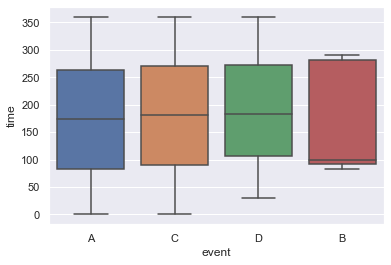

In [42]:
sns.boxplot(x = 'event', y = 'time', data = train_raw_data)
plt.show()

* For class 'B', 50% samples are under time to experiment of 100 secs
* For class 'A', 'C', 'D', 50% samples are under time to experiment of 175 secs

In [29]:
print("NAN sum if any!")
train_raw_data.isna().sum()

NAN sum if any!


crew          0
experiment    0
time          0
seat          0
eeg_fp1       0
eeg_f7        0
eeg_f8        0
eeg_t4        0
eeg_t6        0
eeg_t5        0
eeg_t3        0
eeg_fp2       0
eeg_o1        0
eeg_p3        0
eeg_pz        0
eeg_f3        0
eeg_fz        0
eeg_f4        0
eeg_c4        0
eeg_p4        0
eeg_poz       0
eeg_c3        0
eeg_cz        0
eeg_o2        0
ecg           0
r             0
gsr           0
event         0
dtype: int64

**No NAN found**

In [31]:
train_raw_data[['ecg', 'r', 'gsr']].head()

,ecg,r,gsr
0,-4520.0,817.705994,388.829987
1,-4520.0,817.705994,388.829987
2,-4520.0,817.705994,388.829987
3,-4520.0,817.705994,388.829987
4,-4520.0,817.705994,388.829987


### ECG stats

In [36]:
train_raw_data['ecg'].describe()

count    4.867421e+06
mean     5.285460e+03
std      1.214126e+04
min     -1.858570e+04
25%     -2.550070e+03
50%      5.920510e+03
75%      1.029010e+04
max      3.418830e+04
Name: ecg, dtype: float64

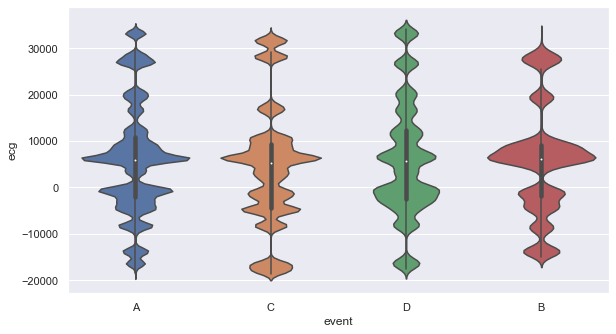

In [12]:
sns.violinplot(x = 'event', y = 'ecg', data = train_raw_data)
plt.show()

* Outliers are there, for A, C, and B has many outliers compared to D, those extreme data points may be helpful 'cause there are chances with those extreme cases pilots likely to be entered in any of the 3 states.

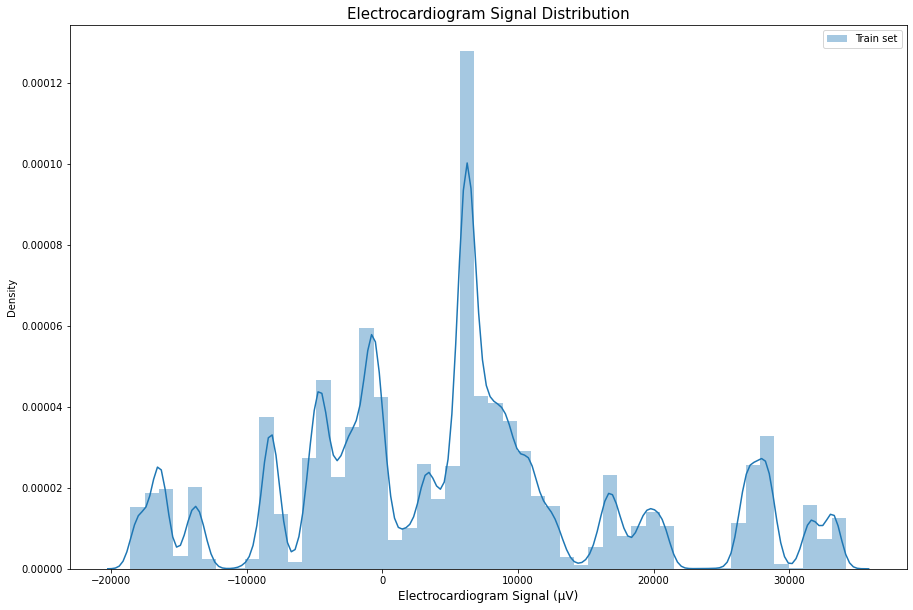

In [18]:
plt.figure(figsize=(15,10)) 
sns.distplot(train_raw_data['ecg'], label='Train set')
plt.legend()
plt.xlabel("Electrocardiogram Signal (µV)", fontsize=12)
plt.title("Electrocardiogram Signal Distribution", fontsize=15)
plt.show()

There is a particular ECG signal more frequent, can see in the middle, which gives a bit essence of Normal distribution

### Respiration Stats

In [37]:
train_raw_data['r'].describe()

count    4.867421e+06
mean     7.376090e+02
std      8.187979e+01
min      4.820600e+02
25%      6.631430e+02
50%      7.434380e+02
75%      8.134120e+02
max      8.401840e+02
Name: r, dtype: float64

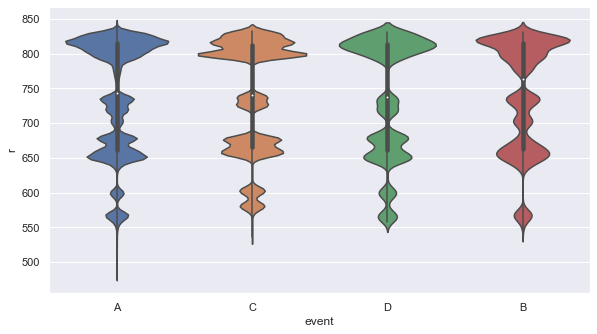

In [22]:
sns.violinplot(x = 'event', y = 'r', data = train_raw_data)
plt.show()

* So many irregularities, the 50th percentile for classes A, C, and D are comparable but it's a little bit high for class B. Frequencies of particular 'r' values getting high after 750 microvolts for class 'B' but for classes A, B, and C it's a bit more around 780(approx).

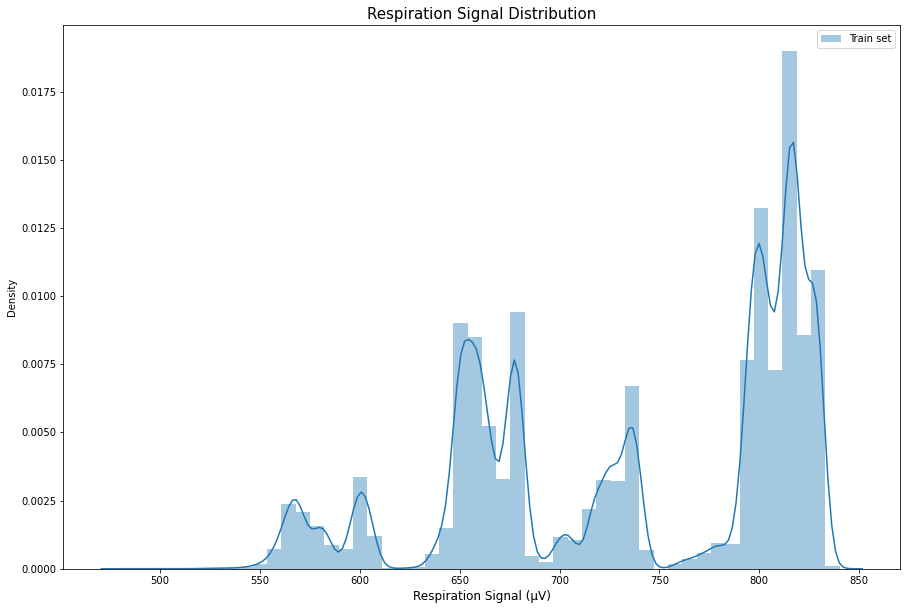

In [19]:
plt.figure(figsize=(15,10))
sns.distplot(train_raw_data['r'], label='Train set')
plt.legend()
plt.xlabel("Respiration Signal (µV)", fontsize=12)
plt.title("Respiration Signal Distribution", fontsize=15)
plt.show()

* Not at all normal, Highly negatively Skewed
* the majority of signals lie between (750, 850) microvolt.

### GSR stats

In [38]:
train_raw_data['gsr'].describe()

count    4.867421e+06
mean     8.518467e+02
std      5.039324e+02
min      0.000000e+00
25%      5.241140e+02
50%      7.701970e+02
75%      1.197120e+03
max      1.999860e+03
Name: gsr, dtype: float64

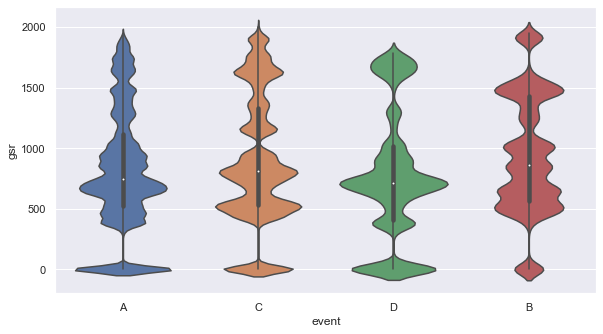

In [28]:
sns.violinplot(x = 'event', y = 'gsr', data = train_raw_data)
plt.show()

* Again class 'B' has a different plot, the 75th percentile value for GSR is quite high while for 'A' and 'D' it's quite low, and for 'C' it's high but lower than 'B', but not outliers are present!

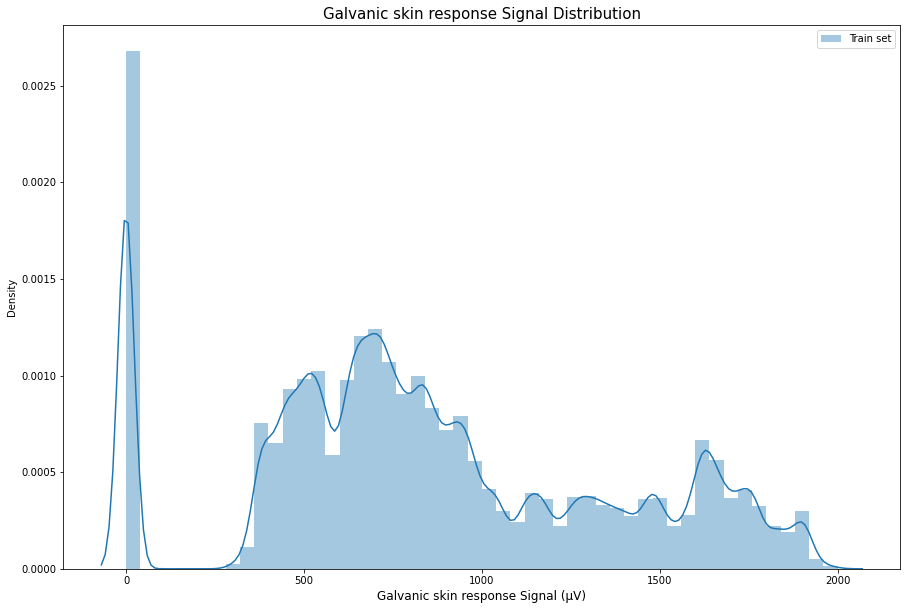

In [21]:
plt.figure(figsize=(15,10)) 
sns.distplot(train_raw_data['gsr'], label='Train set')
plt.legend()
plt.xlabel("Galvanic skin response Signal (µV)", fontsize=12)
plt.title("Galvanic skin response Signal Distribution", fontsize=15)
plt.show()

* Higly Positively skewed, and most of the time the SKin electrical responses are ZERO, this may be useful feature
* sudden peak at 0 microvolts then between 250–1000 most of the data can be seen.

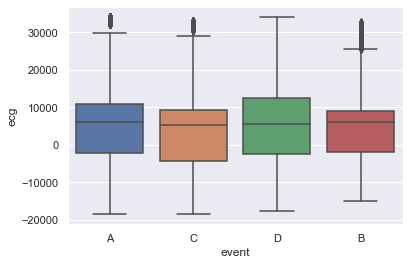

In [33]:
sns.boxplot(x = 'event', y = 'ecg', data = train_raw_data)
plt.show()

* All class Box Plots for ECG are comparable with very little variation, can see some outliers are also there

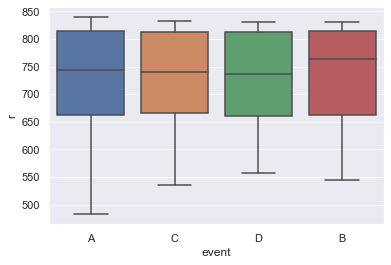

In [34]:
sns.boxplot(x = 'event', y = 'r', data = train_raw_data)
plt.show()

* All class Box Plots for 'r' are almost exactly same with little variation in CLASS 'B', can see no outliers are there

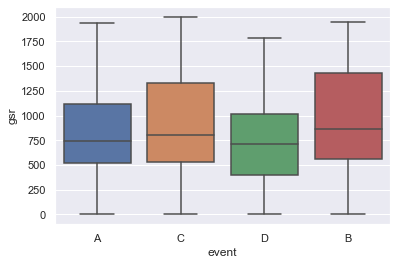

In [35]:
sns.boxplot(x = 'event', y = 'gsr', data = train_raw_data)
plt.show()

* In 'gsr', can see some variations in classes, 'B' and 'C' (50-75) percentile is quite High compared to others, anyways No outliers

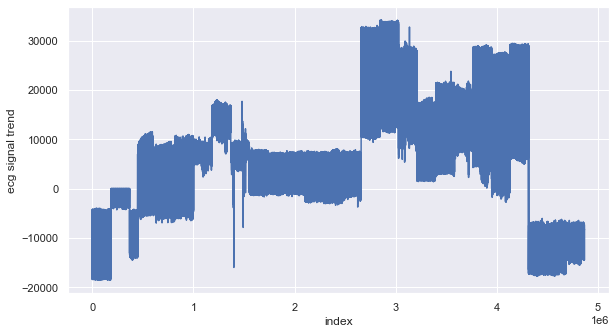

In [14]:
plt.plot(range(train_raw_data.shape[0]), train_raw_data['ecg'])
plt.xlabel('index')
plt.ylabel('ecg signal trend')
plt.show()

* Too noisy

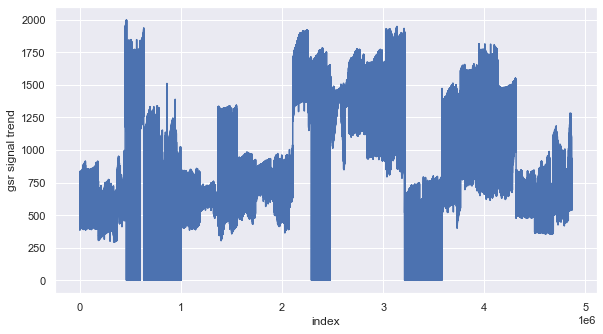

In [31]:
plt.plot(range(train_raw_data.shape[0]), train_raw_data['gsr'])
plt.xlabel('index')
plt.ylabel('gsr signal trend')
plt.show()

* Too noisy

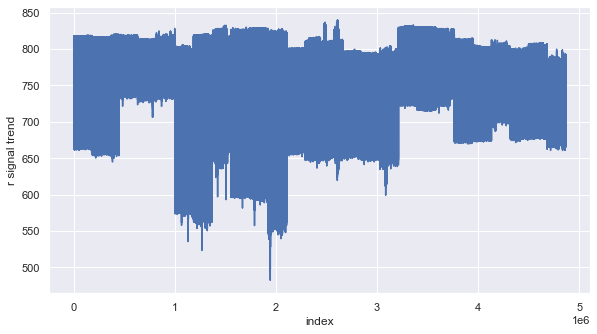

In [20]:
plt.plot(range(train_raw_data.shape[0]), train_raw_data['r'])
plt.xlabel('index')
plt.ylabel('r signal trend')
plt.show()

* Too noisy

#### Getting distribution for those pilot impacted by 'CA' and not

In [15]:
exp_CA_event_C = train_raw_data[(train_raw_data['seat']==1) & \
                    (train_raw_data['crew']==1) & \
                    (train_raw_data['event']=='C') & \
                    (train_raw_data['experiment']=='CA')].sort_values(by='time').iloc[:]

exp_CA_event_A = train_raw_data[(train_raw_data['seat']==1) & \
                    (train_raw_data['crew']==1) & \
                    (train_raw_data['event']=='A') & \
                    (train_raw_data['experiment']=='CA')].sort_values(by='time').iloc[:]

#### Experiment 'CA' performed and 'CA' induced

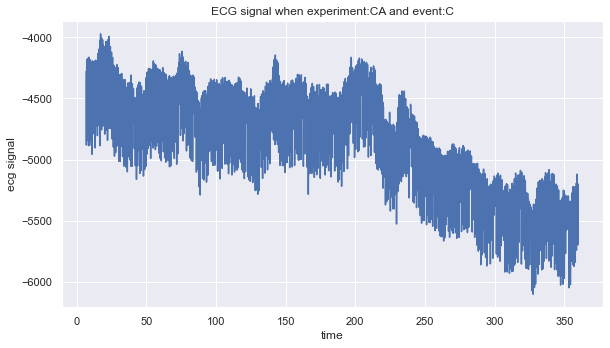

In [17]:
plt.plot(exp_CA_event_C['time'], exp_CA_event_C['ecg'])
plt.xlabel("time")
plt.ylabel('ecg signal')
plt.title("ECG signal when experiment:CA and event:C")
plt.show()

* Deep in the Experiments negative impulses are likely to occur
* An experiment performed 'CA' and event induced is also 'CA', deep in time the signals getting more negative, can be seen decrement in the trend after 200 seconds.

#### Experiment 'CA' performed and nothing induced (Baseline)

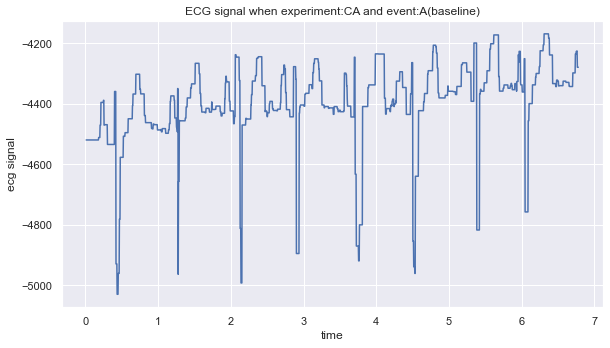

In [19]:
plt.plot(exp_CA_event_A['time'], exp_CA_event_A['ecg'])
plt.xlabel("time")
plt.ylabel('ecg signal')
plt.title("ECG signal when experiment:CA and event:A(baseline)")
plt.show()

* Deep in the experiment, Pilots are more likely to be affected  as 'BASELINE' doesn't remain, deep in the experiment
* An experiment performed 'CA' and nothing induced in pilots, happed only at the initial stage of the experiments, which means deep in the experiment pilots are likely to induce one of the three states.

#### Experiment 'CA' performed and 'CA' induced, Impacted(pilots) 'r' signals

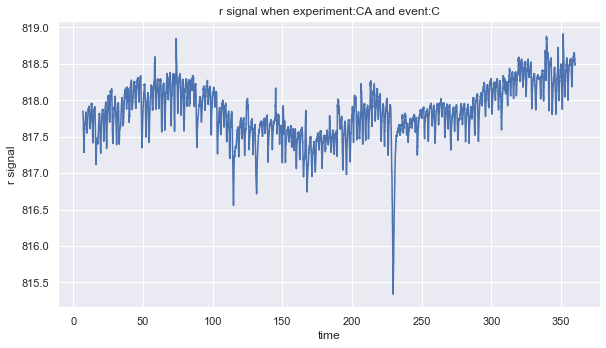

In [24]:
plt.plot(exp_CA_event_C['time'], exp_CA_event_C['r'])
plt.xlabel("time")
plt.ylabel('r signal')
plt.title("r signal when experiment:CA and event:C")
plt.show()

* Low and high spikes can be seen in this plot, in between 150–300 seconds, 'r' signals are comparatively from its extremums. 'r' signals revolved between (817–818.5) microvolts

#### Experiment 'CA' performed and nothing induced, Not impacted

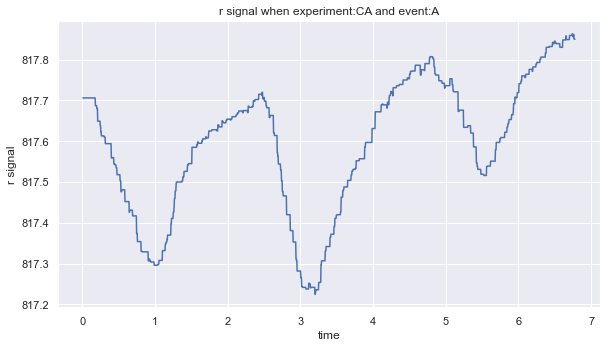

In [27]:
plt.plot(exp_CA_event_A['time'], exp_CA_event_A['r'])
plt.xlabel("time")
plt.ylabel('r signal')
plt.title("r signal when experiment:CA and event:A")
plt.show()

* This might be useful for the model, for no event 'r' signals revolved in between (817.3–817.8) microvolts, and when the event occurred 'r' signals were in between (817–818.5) microvolts. 'No event' happened only at the beginning of the experiment.

#### Experiment 'CA' performed and 'CA' induced, Impacted

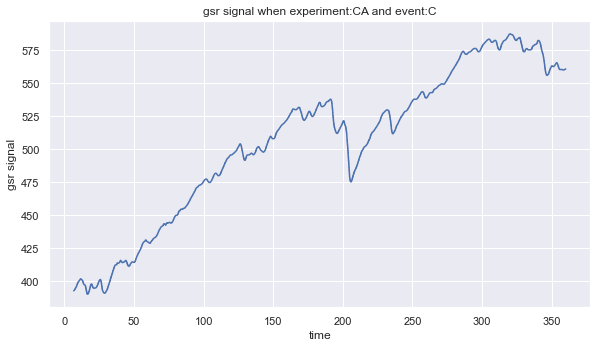

In [32]:
plt.plot(exp_CA_event_C['time'], exp_CA_event_C['gsr'])
plt.xlabel("time")
plt.ylabel('gsr signal')
plt.title("gsr signal when experiment:CA and event:C")
plt.show()

* As we go deep into the experiment the skin's electrical responses are also getting high, and the range is (400–575) microvolts.

#### Experiment 'CA' performed and nothing induced, not impacted

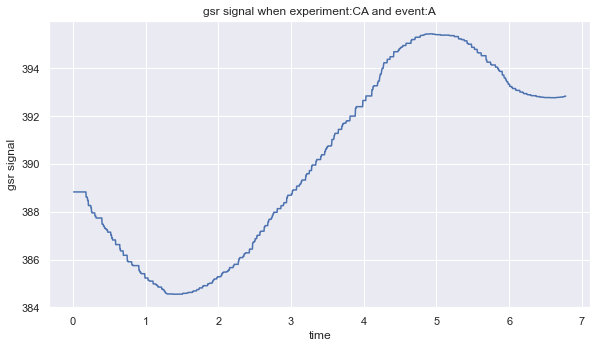

In [34]:
plt.plot(exp_CA_event_A['time'], exp_CA_event_A['gsr'])
plt.xlabel("time")
plt.ylabel('gsr signal')
plt.title("gsr signal when experiment:CA and event:A")
plt.show()

* 'No event' happened only at the beginning of the experiment, and the range of the signal is (384–396) microvolts. It's logical that gsr value range for 'No event' is low compared to the experiment when event induced (400–575) microvolts.

### EEG feature Distribution

In [127]:
eeg_features = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]

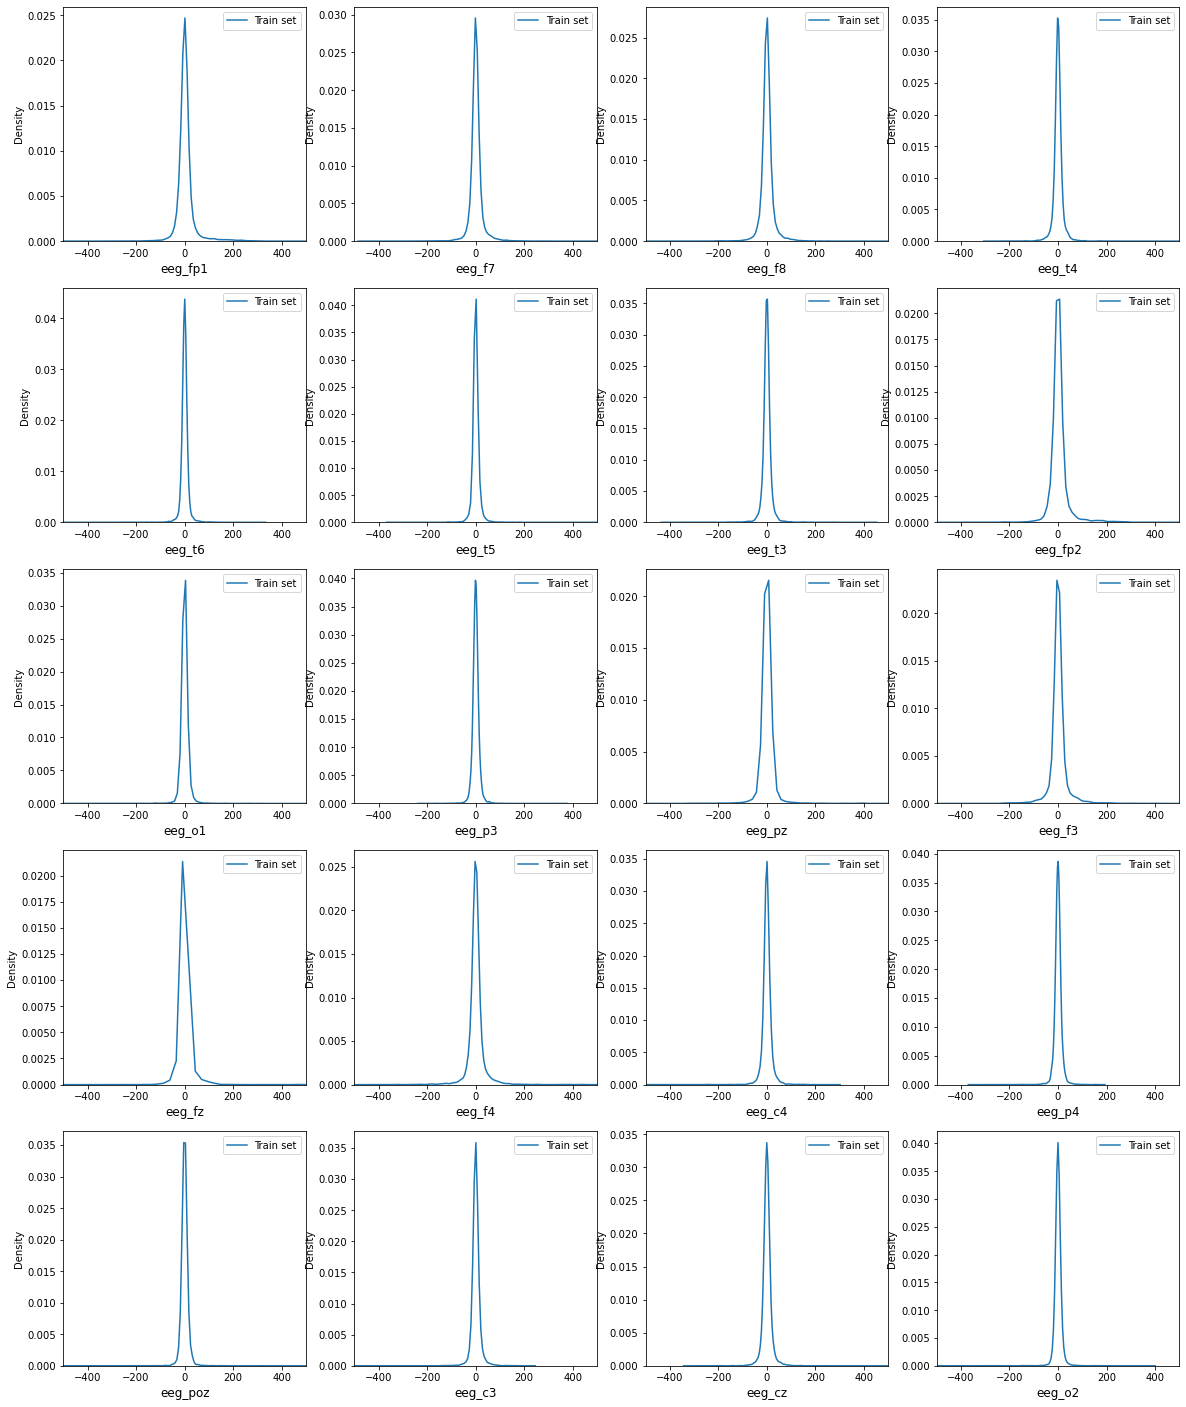

In [133]:
plt.figure(figsize=(20,25))
plt.title('Eeg features distributions')
i = 0
for eeg in eeg_features:
    i += 1
    plt.subplot(5, 4, i) 
    sns.distplot(train_raw_data.sample(10000)[eeg], label='Train set', hist=False)
    plt.xlim((-500, 500))
    plt.legend()
    plt.xlabel(eeg, fontsize=12)
plt.show()

### Looks all normally distributed

### Try to extract other waves in ECG

In [30]:
df_ca = train_raw_data[(train_raw_data['experiment']=='CA') & (train_raw_data['crew']==1) & (train_raw_data['event']=='C')]
df_da = train_raw_data[(train_raw_data['experiment']=='DA') & (train_raw_data['crew']==1) & (train_raw_data['event']=='D')]
df_ss = train_raw_data[(train_raw_data['experiment']=='SS') & (train_raw_data['crew']==1) & (train_raw_data['event']=='B')]

In [31]:
signals_CA, info_CA = nk.ecg_process(df_ca['ecg'], sampling_rate=256)

In [32]:
signals_DA, info_DA = nk.ecg_process(df_da['ecg'], sampling_rate=256)

In [33]:
signals_SS, info_SS = nk.ecg_process(df_ss['ecg'], sampling_rate=256)

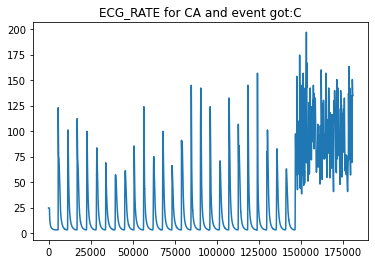

In [45]:
plt.title('ECG_RATE for CA and event got:C')
plt.plot(signals_CA['ECG_Rate'])


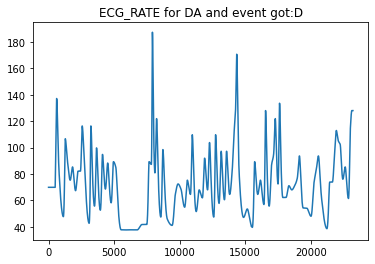

In [46]:
plt.title('ECG_RATE for DA and event got:D')
plt.plot(signals_DA['ECG_Rate'])

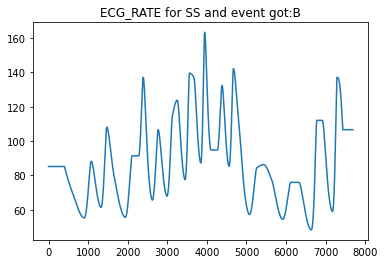

In [48]:
plt.title('ECG_RATE for SS and event got:B')
plt.plot(signals_SS['ECG_Rate'])

#### Every graph is too much irregular, which can be interpreted that everytime these peaks showing induction of cognitive states

In [2]:
# ”ECG_Raw”: the raw signal.
# ”ECG_Clean”: the cleaned signal.
# ”ECG_R_Peaks”: the R-peaks marked as “1” in a list of zeros.
# ”ECG_Rate”: heart rate interpolated between R-peaks.
# ”ECG_P_Peaks”: the P-peaks marked as “1” in a list of zeros
# ”ECG_Q_Peaks”: the Q-peaks marked as “1” in a list of zeros .
# ”ECG_S_Peaks”: the S-peaks marked as “1” in a list of zeros.
# ”ECG_T_Peaks”: the T-peaks marked as “1” in a list of zeros.
# ”ECG_P_Onsets”: the P-onsets marked as “1” in a list of zeros.

In [3]:
# q = ecg.ecg(train_raw_data[train_raw_data['experiment']=='CA']['ecg'].iloc[1:2570], sampling_rate=256, show=False)

### Denoising

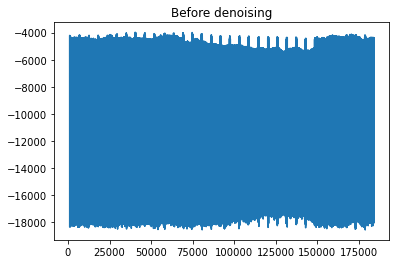

In [71]:
plt.title('Before denoising')
plt.plot(df_ca['ecg'])

### *Lets have a look on the data after cleaning so that interpretation become a bit easy*

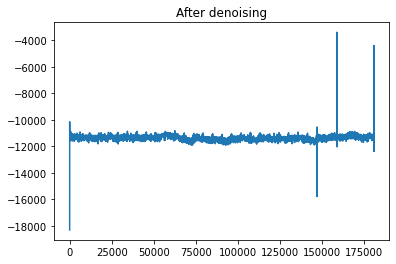

In [72]:
from scipy import signal
b, a = signal.butter(8,0.1)
y = signal.filtfilt(b, a, df_ca['ecg'], padlen=150)
plt.title('After denoising')
plt.plot(y)

#### Still few spikes can be scenes, but can't interpret anything from those

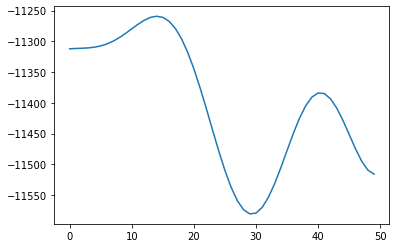

In [73]:
plt.plot(y[450:500])

**Curve now much smoother, these smoothed reading may use in training instead of original noisy readings, but by using that some information loss may occure, because for to have some event this is likely to have sudden changes in the curve for each device and denoising may remove such type of information.|**

### Heart rates without any interpolation IF Event induced in Pilots

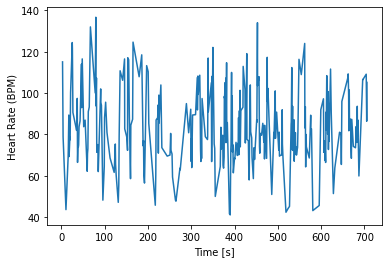

In [79]:
out = ecg.ecg(signal=df_ca['ecg'], sampling_rate=256, show=False)
plt.plot(out['heart_rate_ts'], out['heart_rate'])
plt.ylabel('Heart Rate (BPM)')
plt.xlabel('Time [s]');

#### Too much noisy Heartrate if the experiments performed is 'CA'

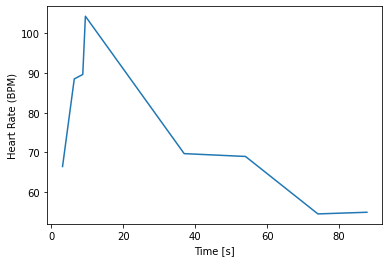

In [84]:
out = ecg.ecg(signal=df_da['ecg'], sampling_rate=256, show=False)
plt.plot(out['heart_rate_ts'], out['heart_rate'])
plt.ylabel('Heart Rate (BPM)')
plt.xlabel('Time [s]');

* Sudden decrement in Heartrate if the experiments performed is 'da'

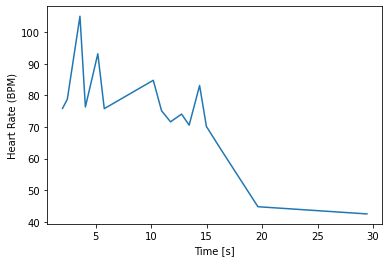

In [81]:
out = ecg.ecg(signal=df_ss['ecg'], sampling_rate=256, show=False)
plt.plot(out['heart_rate_ts'], out['heart_rate'])
plt.ylabel('Heart Rate (BPM)')
plt.xlabel('Time [s]');

#### Sudden decrement in Heartrate with lil noise if the experiments performed is 'SS'

In [75]:
# from biosppy.signals import ecg, resp
# out = resp.resp(y,sampling_rate=256, show=False)
# plt.plot(out['resp_rate_ts'], out['resp_rate'])
# plt.ylabel('Respiratory frequency [Hz]')
# plt.xlabel('Time [s]');

### Heart Rates if people never distracted !

In [89]:
df_ca_a = train_raw_data[(train_raw_data['experiment']=='CA') & (train_raw_data['crew']==1) & (train_raw_data['event']=='A')]
df_da_a = train_raw_data[(train_raw_data['experiment']=='DA') & (train_raw_data['crew']==1) & (train_raw_data['event']=='A')]
df_ss_a = train_raw_data[(train_raw_data['experiment']=='SS') & (train_raw_data['crew']==1) & (train_raw_data['event']=='A')]

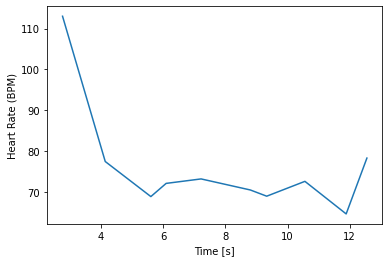

In [93]:
out = ecg.ecg(signal=df_ca_a['ecg'], sampling_rate=256, show=False)
plt.plot(out['heart_rate_ts'], out['heart_rate'])
plt.ylabel('Heart Rate (BPM)')
plt.xlabel('Time [s]');

Easily be seen, if do event induced then hearts are quite low (4-12) secs

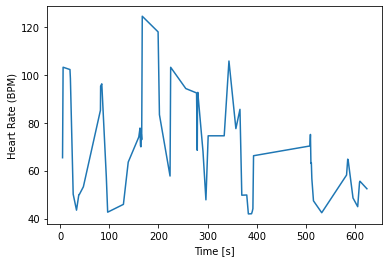

In [94]:
out = ecg.ecg(signal=df_da_a['ecg'], sampling_rate=256, show=False)
plt.plot(out['heart_rate_ts'], out['heart_rate'])
plt.ylabel('Heart Rate (BPM)')
plt.xlabel('Time [s]');

So much irregularities, can't make any precise interpretation

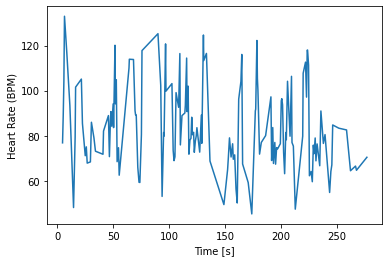

In [92]:
out = ecg.ecg(signal=df_ss_a['ecg'], sampling_rate=256, show=False)
plt.plot(out['heart_rate_ts'], out['heart_rate'])
plt.ylabel('Heart Rate (BPM)')
plt.xlabel('Time [s]');

#### If no event induced in Pilots then those Heart rates couldn't be that much Irregular, but It is, which is quite strange All because of Noise data May be

## CORRELATIONS

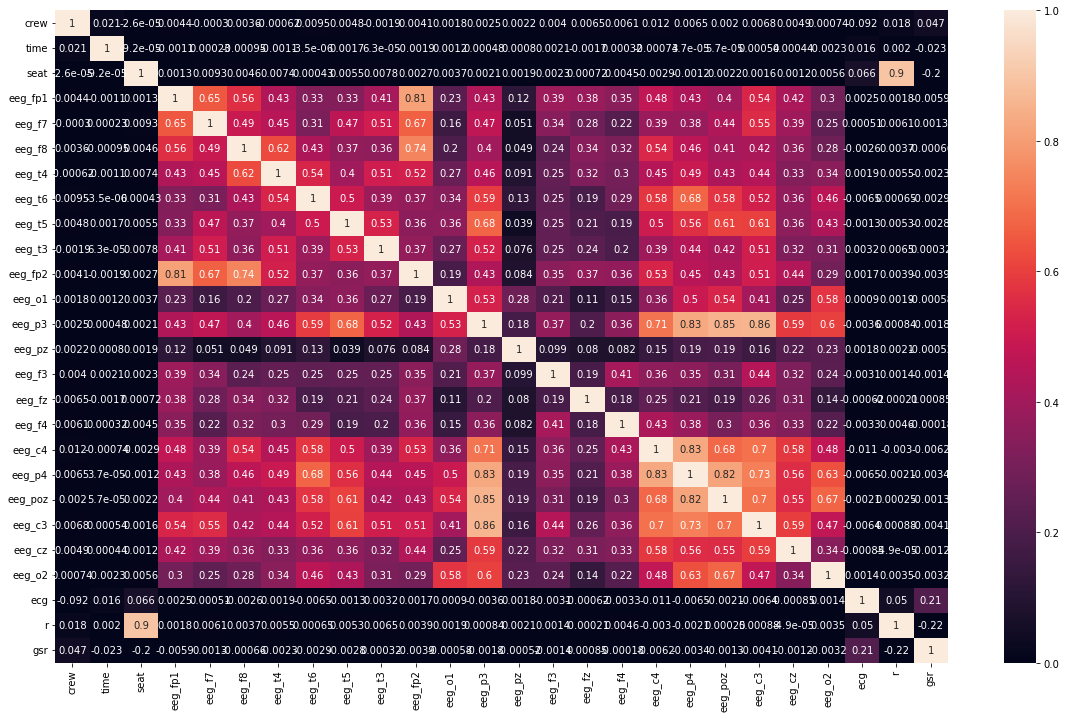

In [98]:
plt.figure(figsize=(20,12))
cor=train_raw_data.corr()
sns.heatmap(cor,annot=True,vmin=0,vmax=1)
plt.show()

##### We can see there is some correlation between GSR, R, ECG because if ECG increased and chances of increment in Respiration and Galvanic skin response will also be high meaning pilot may be in any of the cognitive states
#### EEG results are also correlated only those which are closely attached on head


# Summary

* Data is highly imbalanced
* It is clear we can't separate data based on simple if-else statement
* Hard to extract waves from ECG, as data is too much noisy, not even sure Heart rates will be helpful
* EEG data is Normally distributed which will be helpful to some extent
* Baseline for CA experiments has very low heart rates which is logical as no peak induced in ECG meaning Nothing strange 
  induced pilots
* Correlation can be seen between GSR,R,ECG 
* Correlation can be seen between some EEG electores results, like closely attached electrod results are some what correlated

